In [1]:
!pip install yfinance
!pip install --upgrade pandas-datareader
!pip install pandas-market-calendars
!pip install numba
!pip install nelson_siegel_svensson

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import statsmodels.api as sm
import numpy as np 
import pandas_datareader as web 
import scipy.stats as stats
from numba import jit
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math
from nelson_siegel_svensson.calibrate import calibrate_ns_ols # this model to calibrate the US treasury rate

## Derivative prices

In [3]:
price_list = [1000] #on 15 Aug (initial fixing date)
price_list.append(997.9)
price_list.append(986.6)
price_list.append(985.2)
price_list.append(974.4)
price_list.append(970.9) #22 aug
price_list.append(976.6)
price_list.append(974.3)
price_list.append(982.7)
price_list.append(975.3)
price_list.append(969.6) #29 aug
price_list.append(969.4)
price_list.append(966.7)
price_list.append(951.8)
price_list.append(967.1)
price_list.append(945.3) #5 sep
price_list.append(945.6)
price_list.append(943.1)
price_list.append(948.6)
price_list.append(957.2)
price_list.append(963.6) #12 Sep
price_list.append(948.8) #14 sep
price_list.append(952.8)
price_list.append(945.8)
price_list.append(946.1) #19 sep
price_list.append(937.1)
price_list.append(934.1)
price_list.append(919.5)
price_list.append(852.3) #2
price_list.append(848.8) #26 sep
price_list.append(837.0)
price_list.append(803.2)
price_list.append(811.0)
price_list.append(825.9)
price_list.append(788.0) # 3 oct
price_list.append(810.8)
price_list.append(780.8)
price_list.append(714.3)
price_list.append(773.2)
price_list.append(778.8) # 10 oct
price_list.append(779.6)
price_list.append(762.5)
price_list.append(785.7)
price_list.append(781.2)
price_list.append(788.5) #17 oct
price_list.append(798.6)
price_list.append(800.0)
price_list.append(795.8)
price_list.append(801.6)
price_list.append(815.4) # 24 oct
price_list.append(828.4)
price_list.append(825.0)
price_list.append(774.5)
price_list.append(789.9)
price_list.append(806.6) # 31 oct
price_list.append(818.2)
price_list.append(823.6)
price_list.append(820.7) # 3 nov
price_list.append(831.7)
price_list.append(817.7)
# price_list.append(826.6) # 8 nov

## Payoff function

In [4]:
# without early redemption or callable
def payoff(Spath, t, s0 = 5.42, denom = 1000):
  # determine coupon amount
  coupon = 0.1
  if t > 0.75:
    coupon = 0.025
  elif t > 0.5:
    coupon = 0.05
  elif t > 0.25:
    coupon = 0.075
  Smin = min(Spath)
  # if closes at or above initial level
  if Spath[-1] >= 5.42:
    return denom+coupon*denom
  # if barrier occurs
  elif Smin <= 2.71:
    return Spath[-1]*184.5+coupon*denom
  # if no barrier occurs
  else:
    return denom+coupon*denom

## Simulation using GBM

In [5]:
@jit
def simGBMpath(nsim, s0, v, sd, deltat, tau,Z=-1):
  m = int(tau/deltat) #number of periods
  Smatrix = np.zeros((nsim, m+1))
 # print(m)
  if(type(Z)!=np.ndarray):
    Z = np.random.normal(0,1,size=(nsim, m))
  for i in range(nsim):
    Smatrix[i][0] = s0
    for j in range(1,m+1):
      logdiff = v*deltat - 0.5*(sd**2)*deltat + sd*np.sqrt(deltat)*Z[i][j-1]
      Smatrix[i][j] = Smatrix[i][j-1]*np.exp(logdiff)
  return Smatrix

## Functions for Variance Reduction

In [6]:
# antithetic 
@jit
def SimGBMexactAV(Nsim,S0,v,sigma,Deltat,T,collate=False,Z=-1):
  m=int(T/Deltat) # number of periods
  S=np.full((Nsim, m+1), S0)
  Stilde=np.full((Nsim, m+1), S0)
  if(type(Z)!=np.ndarray):
    Z=np.random.normal(0,1,size=(Nsim, m))

  for i in range(0,Nsim):
    for j in range(1,m+1):
        S[i,j]=S[i,j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[i][j-1])
        Stilde[i,j]=Stilde[i,j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*(-Z[i][j-1]))
  
  
  return np.vstack((S,Stilde))

In [7]:
# control variate (if min=false, use final stock price)
@jit
def SimGBMexactCVRiskNeutral(Nsim,S0,v,r,sigma,Deltat,T,minimum=False,payoff_t=0,Z=-1):
  gbm_path=simGBMpath(Nsim, S0, r, sigma, Deltat, T)
  payoff_sim = np.exp(-r*T)*np.apply_along_axis(payoff, 1, gbm_path,payoff_t)
  if(minimum):
      c=-np.cov(payoff_sim,[min(i) for i in gbm_path])/(S0**2*np.exp(2*r*T)*(np.exp(sigma**2*T)-1))
  else:
      c=-np.cov(payoff_sim,[i[-1] for i in gbm_path])/(S0**2*np.exp(2*r*T)*(np.exp(sigma**2*T)-1))
  c=c[0][1]
  if(type(Z)==np.ndarray):
    gbm_path=simGBMpath(Nsim, S0, r, sigma, Deltat, T,Z=Z)
  else:
    gbm_path=simGBMpath(Nsim, S0, r, sigma, Deltat, T)

  payoff_sim = np.exp(-r*T)*np.apply_along_axis(payoff, 1, gbm_path,payoff_t)
  if(minimum):
    payoff_CV=payoff_sim+c*([min(i) for i in gbm_path]-S0*np.exp(r*T))
  else:
    payoff_CV=payoff_sim+c*([i[-1] for i in gbm_path]-S0*np.exp(r*T))


  return payoff_CV


In [8]:
@jit
def SimGBMexactEMS(Nsim,S0,v,r,sigma,Deltat,T,Z=-1):
  if(type(Z)==np.ndarray):
    gbm_path=simGBMpath(Nsim, S0, r, sigma, Deltat, T,Z=Z)
  else:
    gbm_path=simGBMpath(Nsim, S0, r, sigma, Deltat, T)

  m=int(T/Deltat) # number of periods
  S=np.full((Nsim, m+1), 0.)
  Z=np.full((Nsim+1, m+1), 0.)
  S[:,0]=gbm_path[:,0]

  for j in range(1,m+1):
    Z[:Nsim,j-1] = S[:,j-1]*gbm_path[:,j]/gbm_path[:,j-1]
    Z[Nsim,j-1]=np.exp(-r*((j-1)*Deltat))*np.mean(Z[:Nsim,j-1])
    S[:,j] = gbm_path[:,0]*Z[0:Nsim,j-1]/Z[Nsim,j-1]

  return S

## Backtesting for 61 days

In [9]:
start_date = "2022-08-15"
today = "2022-11-09" # end date of our backtesting
tickers=["CSGN.SW"]
backtest_period = yf.download(tickers, 
                      start=start_date, 
                      end=today, 
                      progress=False)
print("number of days: ",len(backtest_period))
Nsim=10000
dt = 1/252
r = 3.26/100
T = 1
t = 0
m = int(T/dt)


1 Failed download:
['CSGN.SW']: Exception('%ticker%: No timezone found, symbol may be delisted')


number of days:  0


In [10]:
prices_array=[]
for date in backtest_period.index:
  end_date = date + DT.timedelta(days=1)
  start_date = end_date - DT.timedelta(days=90)
  data = yf.download(tickers, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
  prices_array.append(np.array(data["Adj Close"]))
backtest_period.reset_index(inplace=True)

In [11]:
backtest_period.head()

,Date,Open,High,Low,Close,Adj Close,Volume


In [12]:
backtest_period.tail()

,Date,Open,High,Low,Close,Adj Close,Volume


Retrieving interest rate data for risk free rate r

In [ ]:
end='11/8/2022'
rates=pd.read_csv('daily-treasury-rates.csv',index_col=[0]).loc[end:'08/15/2022'][::-1].reset_index(drop=True)
#rates=np.array(rate.loc[date]).astype(float)/100
maturities = np.array([1/12, 2/12, 3/12, 4/12,6/12, 1, 2, 3, 5, 7, 10, 20, 30])
rates.columns = maturities
rates = rates.dropna(how='any',axis=1)
maturities = rates.columns.to_numpy()
rates.shape

In [ ]:
# getting all interpolated interest rate curves for backtesting
curves=[]
for i in backtest_period.index[:-1]:
  try:
    curve_fit, status = calibrate_ns_ols(maturities,rates.iloc[i].to_numpy())
    curves.append(curve_fit)
  except:
    #print("error")
    corrected_rate= rates.iloc[i].to_numpy()
    #print(corrected_rate)
    corrected_rate[3] = corrected_rate[3]-0.05
    curve_fit, status = calibrate_ns_ols(maturities,corrected_rate)
    curves.append(curve_fit)

/usr/local/lib/python3.7/dist-packages/nelson_siegel_svensson/ns.py:38: RuntimeWarning: overflow encountered in exp
  exp_tt0 = exp(-T/tau)
/usr/local/lib/python3.7/dist-packages/nelson_siegel_svensson/ns.py:40: RuntimeWarning: invalid value encountered in subtract
  factor2 = factor1 - exp_tt0


## Generating a common normal variable matrix

In [ ]:
# generating common random variable/common randomness
Z=np.random.normal(0,1,size=(len(backtest_period),Nsim, m))

In [ ]:
def get_statistics(prices, dt):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  v = np.mean(log_returns)/dt
  sd = np.std(log_returns)/np.sqrt(dt)
  return v, sd

## Without callable feature

In [ ]:
# GBM without Variance Reduction
final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
GBM_ev=[]

for prices, date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100

  returns_sim = simGBMpath(Nsim, prices[-1], r, sd, dt, tau,Z=Z[date])
  payoff_sim = np.exp(-r*tau)*np.apply_along_axis(payoff, 1, returns_sim,1-tau)
  ev = np.mean(payoff_sim)
  GBM_ev.append(ev)

<ipython-input-5-c53f37d6a270>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simGBMpath" failed type inference due to: No implementation of function Function(<class 'type'>) found for signature:
 
 >>> type(array(float64, 2d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'type': File: numba/core/typing/builtins.py: Line 1069.
    With argument(s): '(array(float64, 2d, C))':
   No match.

During: resolving callee type: Function(<class 'type'>)
During: typing of call at <ipython-input-5-c53f37d6a270> (6)


File "<ipython-input-5-c53f37d6a270>", line 6:
def simGBMpath(nsim, s0, v, sd, deltat, tau,Z=-1):
    <source elided>
 # print(m)
  if(type(Z)!=np.ndarray):
  ^

  @jit
<ipython-input-5-c53f37d6a270>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "simGBMpath" failed type inference due to: Cannot determine Numba t

In [ ]:
# Antithetic Variance Reduction
final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
AV_evs=[]
for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r-sd**2/2
  returns_sim = SimGBMexactAV(int(Nsim/2), prices[-1], rnv_v, sd, dt, tau,Z=Z[date])
  payoff_sim = np.exp(-r*tau)*np.apply_along_axis(payoff, 1, returns_sim,1-tau)
  ev = np.mean(payoff_sim)
  AV_evs.append(ev)

<ipython-input-6-569488e1930a>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "SimGBMexactAV" failed type inference due to: No implementation of function Function(<class 'type'>) found for signature:
 
 >>> type(array(float64, 2d, C))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload of function 'type': File: numba/core/typing/builtins.py: Line 1069.
      With argument(s): '(array(float64, 2d, C))':
     No match.

During: resolving callee type: Function(<class 'type'>)
During: typing of call at <ipython-input-6-569488e1930a> (7)


File "<ipython-input-6-569488e1930a>", line 7:
def SimGBMexactAV(Nsim,S0,v,sigma,Deltat,T,collate=False,Z=-1):
    <source elided>
  Stilde=np.full((Nsim, m+1), S0)
  if(type(Z)!=np.ndarray):
  ^

  @jit
<ipython-input-6-569488e1930a>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "SimGBMexactAV" faile

In [ ]:
# Control Variate Variance Reduction
final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
CV_evs=[]
for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r-sd**2/2

  payoff_sim = SimGBMexactCVRiskNeutral(Nsim, prices[-1], rnv_v,r, sd, dt, tau,minimum=False,payoff_t=1-tau,Z=Z[date])
  ev = np.mean(payoff_sim)
  CV_evs.append(ev)

<ipython-input-7-7a01b11086d5>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "SimGBMexactCVRiskNeutral" failed type inference due to: Untyped global name 'payoff': Cannot determine Numba type of <class 'function'>

File "<ipython-input-7-7a01b11086d5>", line 5:
def SimGBMexactCVRiskNeutral(Nsim,S0,v,r,sigma,Deltat,T,minimum=False,payoff_t=0,Z=-1):
    <source elided>
  gbm_path=simGBMpath(Nsim, S0, r, sigma, Deltat, T)
  payoff_sim = np.exp(-r*T)*np.apply_along_axis(payoff, 1, gbm_path,payoff_t)
  ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "SimGBMexactCVRiskNeutral" was compiled in object mode without forceobj=True.

File "<ipython-input-7-7a01b11086d5>", line 3:
@jit
def SimGBMexactCVRiskNeutral(Nsim,S0,v,r,sigma,Deltat,T,minimum=False,payoff_t=0,Z=-1):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:162: NumbaDepr

In [ ]:
# Control Variate with Min as the control
final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
CV_min_evs=[]
for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r-sd**2/2

  payoff_sim = SimGBMexactCVRiskNeutral(Nsim, prices[-1], rnv_v,r, sd, dt, tau,minimum=True,payoff_t=1-tau,Z=Z[date])
  ev = np.mean(payoff_sim)
  CV_min_evs.append(ev)

In [ ]:
# EMS Variance Reduction
final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
EMS_evs=[]

for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r-sd**2/2

  returns_sim = SimGBMexactEMS(Nsim, prices[-1], rnv_v, r, sd, dt, tau,Z=Z[date])
  payoff_sim = np.exp(-r*tau)*np.apply_along_axis(payoff, 1, returns_sim,1-tau)
  ev = np.mean(payoff_sim)
  EMS_evs.append(ev)

<ipython-input-8-72319f76fe0c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "SimGBMexactEMS" failed type inference due to: No implementation of function Function(<class 'type'>) found for signature:
 
 >>> type(array(float64, 2d, C))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'type': File: numba/core/typing/builtins.py: Line 1069.
        With argument(s): '(array(float64, 2d, C))':
       No match.

During: resolving callee type: Function(<class 'type'>)
During: typing of call at <ipython-input-8-72319f76fe0c> (3)


File "<ipython-input-8-72319f76fe0c>", line 3:
def SimGBMexactEMS(Nsim,S0,v,r,sigma,Deltat,T,Z=-1):
  if(type(Z)==np.ndarray):
  ^

  @jit
<ipython-input-8-72319f76fe0c>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "SimGBMexactEMS" failed type inference due to: Cannot determine Numba type of

In [ ]:
backtest_data = pd.DataFrame(index=backtest_period.index)
while(len(price_list)!=len(backtest_data)):
  price_list.append(None)
backtest_data['Actual'] = price_list[:len(GBM_ev)]
backtest_data['GBM'] = GBM_ev
backtest_data['AV'] = AV_evs
backtest_data['CV'] = CV_evs
backtest_data['CV_with_min'] = CV_min_evs
backtest_data['EMS'] = EMS_evs
backtest_data.dropna(inplace=True)
backtest_data.head()

,Actual,GBM,AV,CV,CV_with_min,EMS
0,1000.0,998.189693,998.991869,998.478823,1026.949994,998.330108
1,997.9,1001.536296,999.969542,1001.090609,1029.459734,1000.684225
2,986.6,982.004743,983.153049,982.632755,1015.785495,983.307541
3,985.2,987.393141,988.680581,987.967400,1018.658997,988.319142
4,974.4,977.608196,976.706411,976.927328,1013.633996,976.435416


Text(0, 0.5, 'Derivative Price in CHF')

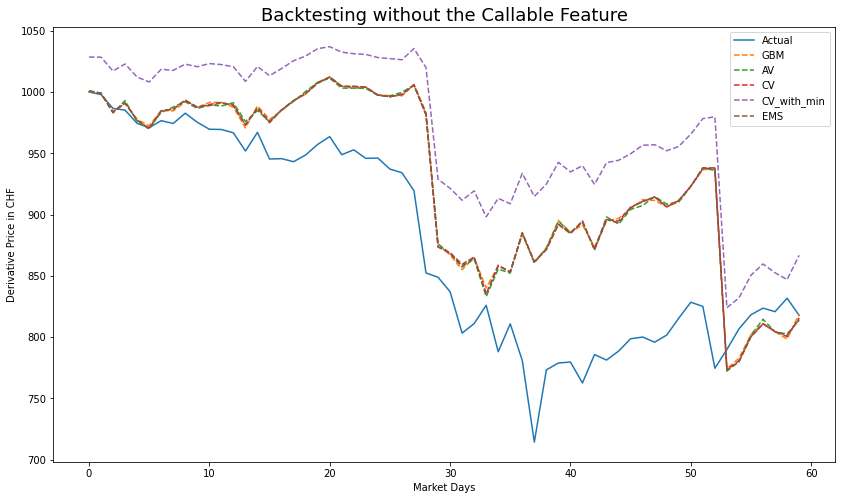

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Backtesting without the Callable Feature',fontdict={"fontsize":18})

backtest_data['Actual'].plot(legend=True)
backtest_data['GBM'].plot(legend=True,style="--")
backtest_data['AV'].plot(legend=True,style="--")
backtest_data['CV'].plot(legend=True,style="--")
backtest_data['CV_with_min'].plot(legend=True,style="--")
backtest_data['EMS'].plot(legend=True,style="--")

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in CHF')

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['GBM'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['GBM'].to_list())

print(f'Mean Absolute Error for GBM : {mean_abs_error}')
print(f'Mean Squared Error for GBM : {mean_sq_error}')
print()

mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['AV'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['AV'].to_list())

print(f'Mean Absolute Error for AV : {mean_abs_error}')
print(f'Mean Squared Error for AV : {mean_sq_error}')
print()

mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['CV'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['CV'].to_list())

print(f'Mean Absolute Error for CV : {mean_abs_error}')
print(f'Mean Squared Error for CV : {mean_sq_error}')
print()

mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['CV_with_min'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['CV_with_min'].to_list())

print(f'Mean Absolute Error for CV_with_min : {mean_abs_error}')
print(f'Mean Squared Error for CV_with_min : {mean_sq_error}')
print()

mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['EMS'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['EMS'].to_list())

print(f'Mean Absolute Error for EMS : {mean_abs_error}')
print(f'Mean Squared Error for EMS : {mean_sq_error}')
print()

Mean Absolute Error for GBM : 55.108316689457084
Mean Squared Error for GBM : 4942.879629798326

Mean Absolute Error for AV : 54.93913029516249
Mean Squared Error for AV : 4927.0052271524755

Mean Absolute Error for CV : 55.18505844228136
Mean Squared Error for CV : 4954.583445501281

Mean Absolute Error for CV_with_min : 91.79247474165692
Mean Squared Error for CV_with_min : 11045.839336749192

Mean Absolute Error for EMS : 55.19217407386811
Mean Squared Error for EMS : 4948.9410609937095



### Estimating Sensitivities

In [ ]:
@jit
def SimGBMpmh(Nsim, S0, v, sigma, Deltat, T, h, collate=False, Z=-1):
  m = int(T/Deltat) #number of periods
  Splush = np.full((Nsim, m+1), S0+h)
  S = np.full((Nsim, m+1), S0)
  Sminush = np.full((Nsim, m+1), S0-h)
  for i in range(0,Nsim):
    for j in range(1,m+1):
      Splush[i][j] = Splush[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[i][j-1])
      S[i][j] = S[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[i][j-1])
      Sminush[i][j] = Sminush[i][j-1]*np.exp(v*Deltat+sigma*np.sqrt(Deltat)*Z[i][j-1])
  return Splush, S, Sminush

In [ ]:
final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
GBM_Delta_noncall = []
GBM_Gamma_noncall = []

for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r-sd**2/2
  h=prices[-1]*0.01

  gbm_Splush, gbm_S, gbm_Sminush=SimGBMpmh(Nsim, prices[-1], rnv_v, sd, dt, tau, h, Z=Z[date])

  SimNoteSplush=np.apply_along_axis(payoff, 1, gbm_Splush, 1-tau)
  SimNoteS=np.apply_along_axis(payoff, 1, gbm_S, 1-tau)
  SimNoteSminush=np.apply_along_axis(payoff, 1, gbm_Sminush, 1-tau)

  NoteValueplush=np.exp(-r*tau)*np.mean(SimNoteSplush)
  NoteValue=np.exp(-r*tau)*np.mean(SimNoteS)
  NoteValueminush=np.exp(-r*tau)*np.mean(SimNoteSminush)

  NoteDelta=(NoteValueplush-NoteValueminush)/(2*h)
  NoteGamma=(NoteValueplush-2*NoteValue+NoteValueminush)/(h**2)

  GBM_Delta_noncall.append(NoteDelta)
  GBM_Gamma_noncall.append(NoteGamma)

In [ ]:
backtest_data['Delta'] = GBM_Delta_noncall[:60]
backtest_data['Gamma'] = GBM_Gamma_noncall[:60]
backtest_data.dropna(inplace=True)

Text(0.5, 0, 'Market Days')

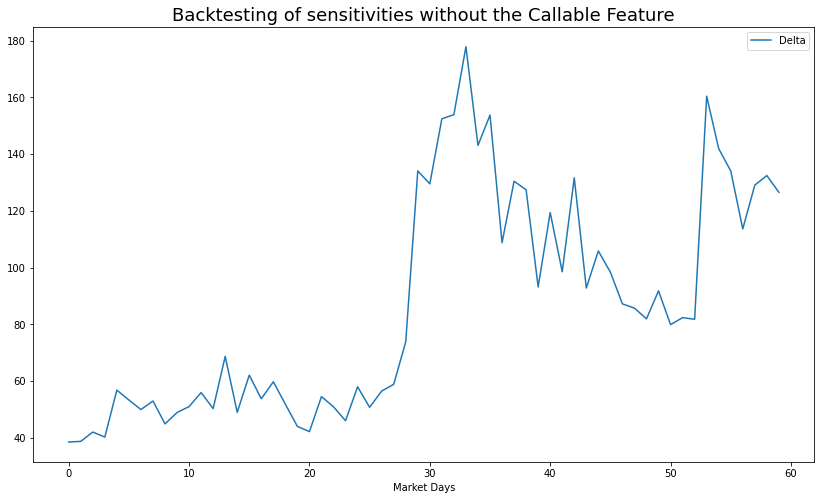

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Backtesting of sensitivities without the Callable Feature',fontdict={"fontsize":18})

backtest_data['Delta'].plot(legend=True)
plt.xlabel('Market Days')

Text(0.5, 0, 'Market Days')

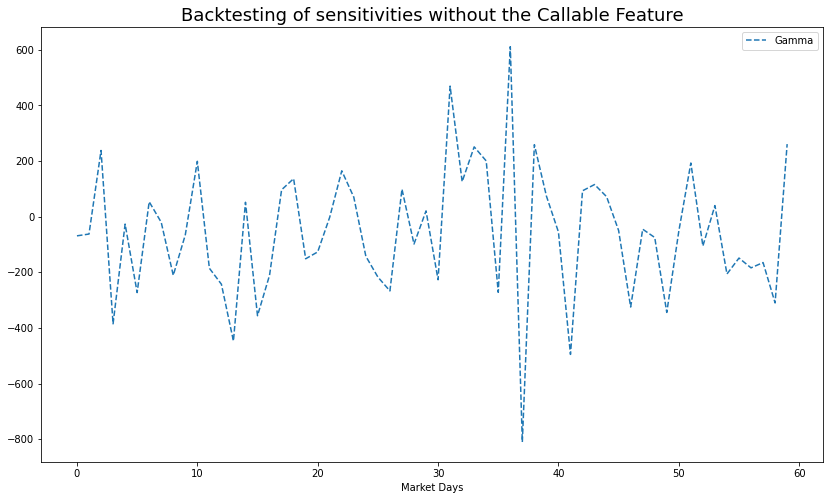

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Backtesting of sensitivities without the Callable Feature',fontdict={"fontsize":18})

backtest_data['Gamma'].plot(legend=True,style="--")
plt.xlabel('Market Days')

## With callable feature

### Redemption cost function

In [ ]:
def redemption_cost(t, denom = 1000):
  # determine coupon amount
  # t = 0.5, 0.75 only
  if t < 0.5:
    raise Exception("cannot redeem yet")
  elif t < 0.75:
    coupon = 0.05
  elif t < 1.0:
    coupon = 0.075
  else:
    coupon = 0.1
  return denom+coupon*denom

In [ ]:
Nsim=10000
dt = 1/252
r = 3.26/100
T = 1
t = 0

exdates = [126, 189]
extimes = len(exdates)

In [ ]:
# GBM without Variance Reduction
GBM_ev=[]
times_called_GBM = []
for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  returns_sim = simGBMpath(Nsim, prices[-1], r, sd, dt, tau,Z=Z[date])
  payoff_sim = np.apply_along_axis(payoff, 1, returns_sim,1-tau)
  exdates = [126-date, 189-date]
  exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
  extimes = len(exdates)
  # initialize matrix
  V = np.zeros((Nsim, extimes+1))
  exmat = np.zeros((Nsim, extimes)) # exmat[:, -1] = 1
  # V = np.insert(V, extimes, payoff_sim, axis=1)
  V[:,-1] = payoff_sim
  previousstep = delta
  for i,j in enumerate(exdates[::-1]):
    currentstep = j
    # assume all are ITM points
    Y=np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)]
    X=returns_sim[:,currentstep]
    X2=X**2
    X = np.reshape(X, (-1,1))
    X = np.insert(X, 1, X2, axis=1)
    LR = LinearRegression().fit(X, Y)
    F = LR.predict(X)
    #print("coefficients: ",LR.coef_)
    shouldRedeem = np.where(redemption_cost((currentstep+date)*dt) < F, 1, 0)
    exmat[:,-(i+1)] = shouldRedeem
    newvalues = np.where(shouldRedeem, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)])
    V[:, -(i+2)] = newvalues
    previousstep=j

  v0=np.exp(-r*(previousstep-0)*dt)*np.mean(V[:,0])
  GBM_ev.append(v0)
  times_call = np.count_nonzero(exmat, axis=None)
  times_called_GBM.append(times_call)


In [ ]:
# EMS Variance Reduction
EMS_evs=[]
times_called_EMS = []
for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r - (sd**2)/2
  returns_sim = SimGBMexactEMS(Nsim, prices[-1], rnv_v, r, sd, dt, tau,Z=Z[date])
  payoff_sim = np.apply_along_axis(payoff, 1, returns_sim, 1-tau)

  exdates = [126-date, 189-date]
  exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
  extimes = len(exdates)

  V = np.zeros((Nsim, extimes+1))
  exmat = np.zeros((Nsim, extimes))
  V[:,-1] = payoff_sim
  previousstep = delta
  for i,j in enumerate(exdates[::-1]):
    currentstep = j
    # assume all are ITM points
    Y=np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)]
    X=returns_sim[:,currentstep]
    X2=X**2
    X = np.reshape(X, (-1,1))
    X = np.insert(X, 1, X2, axis=1)
    LR = LinearRegression().fit(X, Y)
    F = LR.predict(X)
    #print("coefficients: ",LR.coef_)
    shouldRedeem = np.where(redemption_cost((currentstep+date)*dt) < F, 1, 0)
    exmat[:,-(i+1)] = shouldRedeem
    newvalues = np.where(shouldRedeem, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)])
    V[:, -(i+2)] = newvalues
    previousstep=j

  v0=np.exp(-r*(previousstep-0)*dt)*np.mean(V[:,0])
  EMS_evs.append(v0)
  times_call = np.count_nonzero(exmat, axis=None)
  times_called_EMS.append(times_call)


In [ ]:
backtest_data_callable = pd.DataFrame(index=backtest_period.index)
while(len(price_list)<len(backtest_data_callable)):
  price_list.append(None)
backtest_data_callable['Actual'] = price_list[:len(GBM_ev)]
backtest_data_callable['GBM'] = GBM_ev
backtest_data_callable['EMS'] = EMS_evs
backtest_data_callable.dropna(inplace=True)
backtest_data_callable.head()

,Actual,GBM,EMS
0,1000.0,985.412772,985.525531
1,997.9,988.066416,987.251645
2,986.6,970.064467,971.227756
3,985.2,975.068527,975.881722
4,974.4,966.551227,965.490680


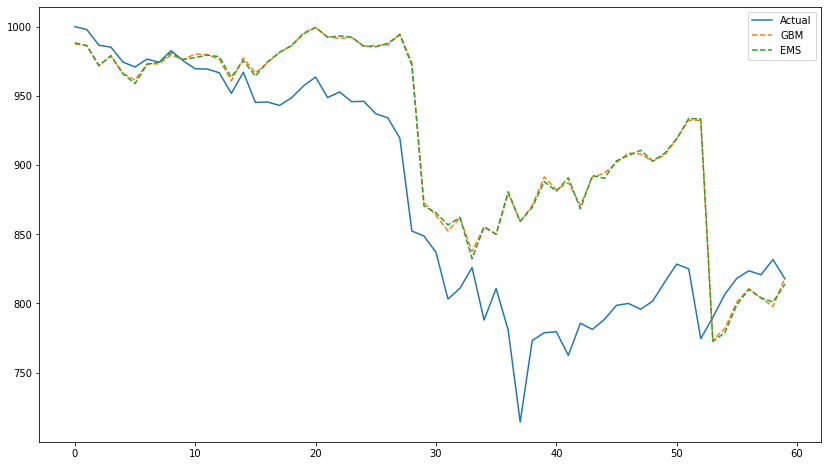

In [ ]:
plt.figure(figsize=(14,8))

backtest_data_callable['Actual'].plot(legend=True)
backtest_data_callable['GBM'].plot(legend=True,style="--")
backtest_data_callable['EMS'].plot(legend=True,style="--")

In [ ]:
diff=(backtest_data[['GBM','EMS']]-backtest_data_callable[['GBM','EMS']]).mean().values[0]
print(f'Using GBM the difference between Callable and Non-callable Estimation of Derivation Price => {diff} CHF')
diff=(backtest_data[['GBM','EMS']]-backtest_data_callable[['GBM','EMS']]).mean().values[1]
print(f'Using EMS the difference between Callable and Non-callable Estimation of Derivation Price => {diff} CHF')

Using GBM the difference between Callable and Non-callable Estimation of Derivation Price => 6.911953116067247 CHF
Using EMS the difference between Callable and Non-callable Estimation of Derivation Price => 6.895775543796121 CHF


In [ ]:
premium = backtest_data['GBM']-backtest_data_callable['GBM']
backtest_data_callable['AV'] = backtest_data['AV'] - premium
backtest_data_callable['CV'] = backtest_data['CV'] - premium
backtest_data_callable['CV_with_min'] = backtest_data['CV_with_min'] - premium

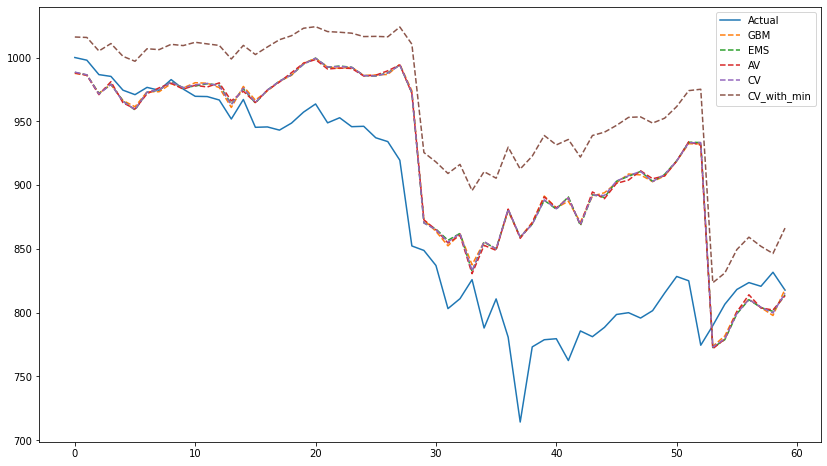

In [ ]:
plt.figure(figsize=(14,8))

backtest_data_callable['Actual'].plot(legend=True)
backtest_data_callable['GBM'].plot(legend=True,style="--")
backtest_data_callable['EMS'].plot(legend=True,style="--")
backtest_data_callable['AV'].plot(legend=True,style="--")
backtest_data_callable['CV'].plot(legend=True,style="--")
backtest_data_callable['CV_with_min'].plot(legend=True,style="--")

### Comparison of callable vs non-callable

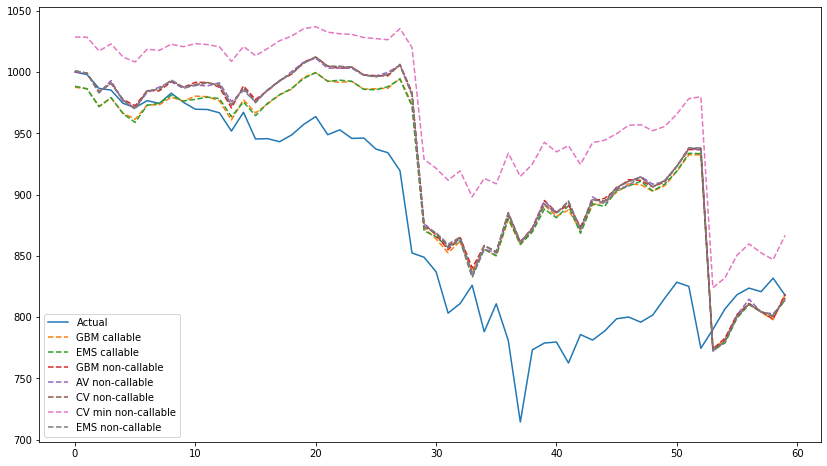

In [ ]:
plt.figure(figsize=(14,8))

backtest_data_callable['Actual'].plot(legend=True)
backtest_data_callable['GBM'].plot(legend=True,style="--",label='GBM callable')
backtest_data_callable['EMS'].plot(legend=True,style="--", label='EMS callable')
backtest_data['GBM'].plot(legend=True,style="--", label='GBM non-callable')
backtest_data['AV'].plot(legend=True,style="--", label='AV non-callable')
backtest_data['CV'].plot(legend=True,style="--", label='CV non-callable')
backtest_data['CV_with_min'].plot(legend=True,style="--", label='CV min non-callable')
backtest_data['EMS'].plot(legend=True,style="--", label='EMS non-callable')


## Estimating Sensitivities

In [ ]:
GBM_Delta_call = []
GBM_Gamma_call = []

for prices,date in zip(prices_array,backtest_period.index):
  delta = 252-date
  tau = (delta)/252
  v, sd = get_statistics(prices, dt)
  try:
    curve_fit=curves[date]
  except:
    curve_fit=curves[date-1]
  r = curve_fit(tau)/100
  rnv_v = r - (sd**2)/2
  h=prices[-1]*0.01

  gbm_Splush, gbm_S, gbm_Sminush=SimGBMpmh(Nsim, prices[-1], rnv_v, sd, dt, tau, h, Z=Z[date])

  SimNoteSplush=np.apply_along_axis(payoff, 1, gbm_Splush, 1-tau)
  SimNoteS=np.apply_along_axis(payoff, 1, gbm_S, 1-tau)
  SimNoteSminush=np.apply_along_axis(payoff, 1, gbm_Sminush, 1-tau)

  exdates = [126-date, 189-date]
  exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
  extimes = len(exdates)

  # initialize matrix
  V_Splush = np.zeros((Nsim, extimes+1))
  V_S = np.zeros((Nsim, extimes+1))
  V_Sminush = np.zeros((Nsim, extimes+1))

  V_Splush[:,-1] = SimNoteSplush
  V_S[:,-1] = SimNoteS
  V_Sminush[:,-1] = SimNoteSminush

  previousstep = delta
  for i,j in enumerate(exdates[::-1]):
    currentstep = j
    # assume all are ITM points
    Y_Splush=np.exp(-r*(previousstep-currentstep)*dt)*V_Splush[:,-(i+1)] # discounting from previuosstep-currentstep
    Y_S=np.exp(-r*(previousstep-currentstep)*dt)*V_S[:,-(i+1)]
    Y_Sminush=np.exp(-r*(previousstep-currentstep)*dt)*V_Sminush[:,-(i+1)]
    
    X_Splush=gbm_Splush[:,currentstep]
    X_S=gbm_S[:,currentstep]
    X_Sminush=gbm_Sminush[:,currentstep]

    X2_Splush=X_Splush**2
    X2_S=X_S**2
    X2_Sminush=X_Sminush**2

    X_Splush = np.reshape(X_Splush, (-1,1))
    X_S = np.reshape(X_S, (-1,1))
    X_Sminush = np.reshape(X_Sminush, (-1,1))

    X_Splush = np.insert(X_Splush, 1, X2_Splush, axis=1)
    X_S = np.insert(X_S, 1, X2_S, axis=1)
    X_Sminush = np.insert(X_Sminush, 1, X2_Sminush, axis=1)

    LR_Splush = LinearRegression().fit(X_Splush, Y_Splush)
    LR_S = LinearRegression().fit(X_S, Y_S)
    LR_Sminush = LinearRegression().fit(X_Sminush, Y_Sminush)

    F_Splush = LR_Splush.predict(X_Splush)
    F_S = LR_S.predict(X_S)
    F_Sminush = LR_Sminush.predict(X_Sminush)

    shouldRedeem_Splush = np.where(redemption_cost((currentstep+date)*dt) < F_Splush, 1, 0)
    shouldRedeem_S = np.where(redemption_cost((currentstep+date)*dt) < F_S, 1, 0)
    shouldRedeem_Sminush = np.where(redemption_cost((currentstep+date)*dt) < F_Sminush, 1, 0)

    newvalues_Splush = np.where(shouldRedeem_Splush, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V_Splush[:,-(i+1)])
    newvalues_S = np.where(shouldRedeem_S, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V_S[:,-(i+1)])
    newvalues_Sminush = np.where(shouldRedeem_Sminush, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V_Sminush[:,-(i+1)])

    V_Splush[:, -(i+2)] = newvalues_Splush
    V_S[:, -(i+2)] = newvalues_S
    V_Sminush[:, -(i+2)] = newvalues_Sminush

    previousstep=j

  v0_Splush=np.exp(-r*(previousstep-0)*dt)*np.mean(V_Splush[:,0])
  v0_S=np.exp(-r*(previousstep-0)*dt)*np.mean(V_S[:,0])
  v0_Sminush=np.exp(-r*(previousstep-0)*dt)*np.mean(V_Sminush[:,0])

  NoteValueplush=v0_Splush
  NoteValue=v0_S
  NoteValueminush=v0_Sminush

  NoteDelta=(NoteValueplush-NoteValueminush)/(2*h)
  NoteGamma=(NoteValueplush-2*NoteValue+NoteValueminush)/(h**2)

  GBM_Delta_call.append(NoteDelta)
  GBM_Gamma_call.append(NoteGamma)

In [ ]:
backtest_data_callable['Delta'] = GBM_Delta_call
backtest_data_callable['Gamma'] = GBM_Gamma_call

Text(0.5, 0, 'Market Days')

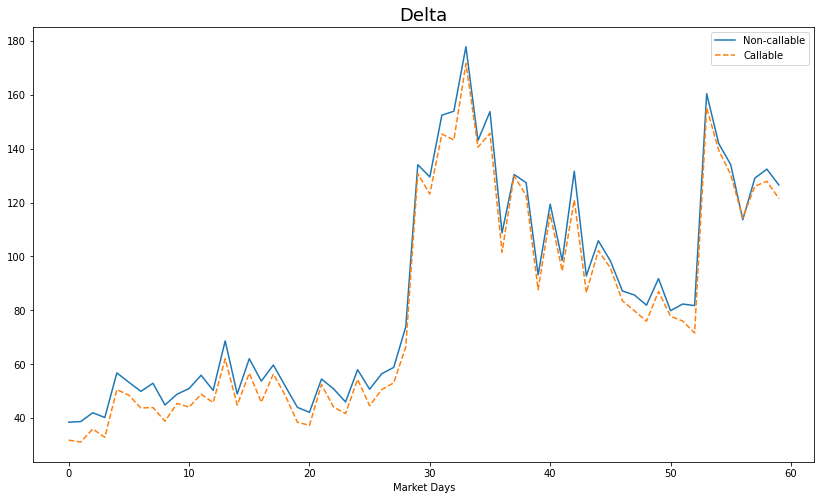

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Delta',fontdict={"fontsize":18})
backtest_data['Delta'].plot(legend=True, label = 'Non-callable')
backtest_data_callable['Delta'].plot(legend=True, style="--", label='Callable')
plt.xlabel('Market Days')

Text(0.5, 0, 'Market Days')

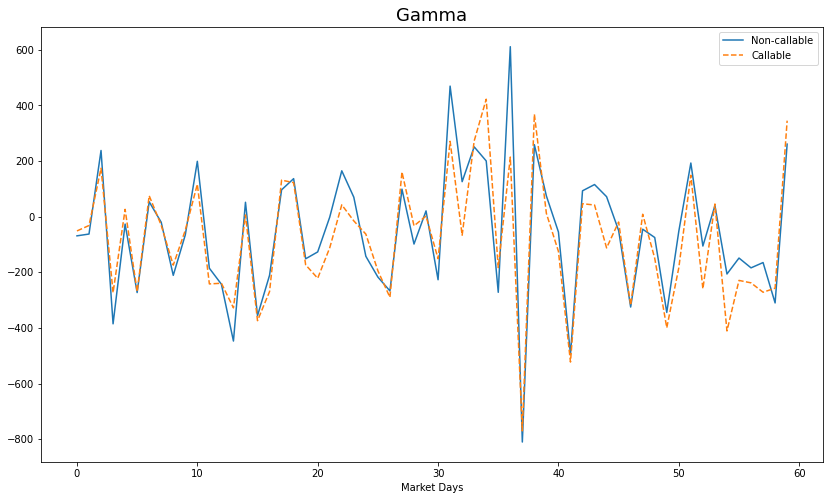

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Gamma',fontdict={"fontsize":18})

backtest_data['Gamma'].plot(legend=True, label='Non-callable')
backtest_data_callable['Gamma'].plot(legend=True,style="--", label='Callable')
plt.xlabel('Market Days')

## Short rate interest model

In [ ]:
ir_df = pd.read_csv("CIL_parameters.csv")
ir_df

,Date,r0,"long term mean, γ",RSS,"discrete drift, Φ","continuous drift, κ","discrete volatility, σa","continuous volatility, σ"
0,08/15/2022,3.23,0.012227,0.005665,0.999012,0.000988,0.005206,0.005209
1,08/16/2022,3.26,0.012353,0.005652,0.998874,0.001127,0.005200,0.005203
2,08/17/2022,3.27,0.012479,0.005652,0.998852,0.001149,0.005200,0.005203
3,08/18/2022,3.24,0.012605,0.005635,0.998656,0.001345,0.005192,0.005196
4,08/19/2022,3.26,0.012731,0.005635,0.998634,0.001367,0.005193,0.005196
...,...,...,...,...,...,...,...,...
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
@jit
def simGBMpath_iv(nsim, s0, v, sd, deltat, tau, spline, Z=-1):
  m = int(tau/deltat) #number of periods
  Smatrix = np.zeros((nsim, m+1))
  Z = np.random.normal(0,1,size=(nsim, m))
  for i in range(nsim):
    Smatrix[i][0] = s0
    for j in range(1,m+1):
      iv = spline(tau-j*deltat,np.log(Smatrix[i][j-1]/4.878))
      if math.isnan(iv):
        iv = sd
      logdiff = v*deltat - 0.5*(iv**2)*deltat + sd*np.sqrt(deltat)*Z[i][j-1]
      # if math.isnan(logdiff):
      #   print("logdiff", logdiff, sd, deltat, Z[i][j-1])
      Smatrix[i][j] = Smatrix[i][j-1]*np.exp(logdiff)
  return Smatrix

In [ ]:
@jit
def CIR(nsim, r0, K, theta, sigma, tau, deltat):
  m = int(tau/deltat) #number of periods
  IRmatrix = np.zeros((nsim, m+1))
  #Z = rng.standard_normal(size=(nsim, m))
  Z=np.random.normal(0,1,size=(Nsim, m))
  #rates = [r0]
  for i in range(nsim):
    IRmatrix[i][0] = r0
    for j in range (1,m+1):
      dr = K*(theta-IRmatrix[i][j-1])*deltat + sigma*math.sqrt(IRmatrix[i][j-1])*Z[i][j-1]
      IRmatrix[i][j] = max(0, IRmatrix[i][j-1] + dr)
  return IRmatrix

In [ ]:
@jit
def simGBM_CILpath(nsim, s0, rates, sd, deltat, tau, Z=-1):
  m = int(tau/deltat) #number of periods
  Smatrix = np.zeros((nsim, m+1))
  for i in range(nsim):
    Smatrix[i][0] = s0
    for j in range(1,m+1):
      v = rates[i][j-1]/100
      logdiff = v*deltat - 0.5*(sd**2)*deltat + sd*np.sqrt(deltat)*Z[i][j-1]
      Smatrix[i][j] = Smatrix[i][j-1]*np.exp(logdiff)
      #print(Smatrix[i][j-1]*np.exp(logdiff))
  return Smatrix

In [ ]:
@jit
def discount_payoff_CIR(nsim, payoffs, rates, deltat, date, tau):
  m = int(tau/deltat) #number of periods
  backpricing_matrix = np.zeros((nsim, m+1))
  for i in range(nsim):
    backpricing_matrix[i][m] = payoffs[i]
    for j in range(m):
      day = int(tau/deltat)+date-j
      discount_rate = rates[i][day]/100
      backpricing_matrix[i][m-j-1] = np.exp(-discount_rate*deltat)*backpricing_matrix[i][m-j]

  return backpricing_matrix[:,0] # mean of the prices at time t

Without callable feature

In [ ]:
T=1
t=0
tau=T-t
Nsim=10000
dt=1/252

final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
CIR_ev=[]

for prices,date in zip(prices_array,backtest_period.index):
  v, sd = get_statistics(prices, dt)
  delta = 252-date
  tau = (delta)/252
  r = ir_df.iloc[date]["r0"]/100
  k = ir_df.iloc[date]["continuous drift, κ"]
  y = ir_df.iloc[date]["long term mean, γ"]
  sigma = ir_df.iloc[date]["continuous volatility, σ"]

  ir_sim = CIR(Nsim,r,k,y,sigma,tau,dt)
  CILprices_sim = simGBM_CILpath(Nsim, prices[-1], ir_sim, sd, dt, tau, Z[date])

  payoff_sim=np.apply_along_axis(payoff, 1, CILprices_sim,0)
  dis_payoff = discount_payoff_CIR(Nsim,payoff_sim,ir_sim,dt,0,tau)

  ev = np.mean(dis_payoff)
  CIR_ev.append(ev)

In [ ]:
backtest_data['CIR'] = CIR_ev[:60]

Text(0, 0.5, 'Derivative Price in CHF')

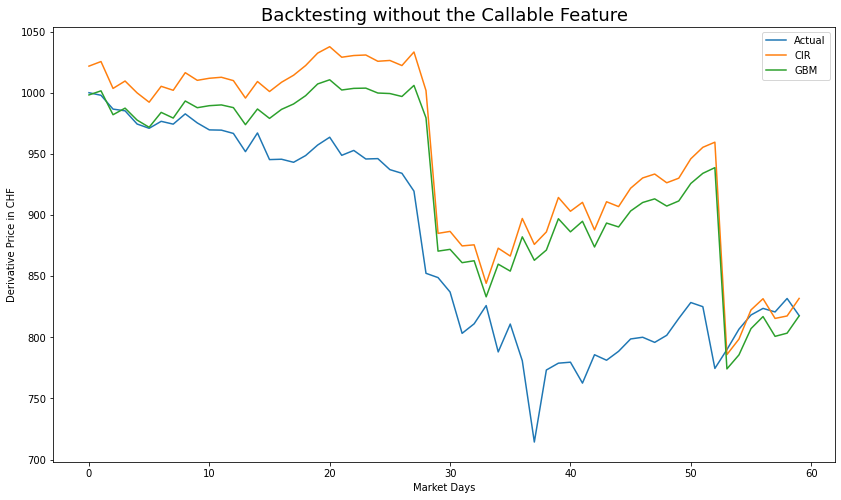

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Backtesting without the Callable Feature',fontdict={"fontsize":18})

backtest_data['Actual'].plot(legend=True)
backtest_data['CIR'].plot(legend=True)
backtest_data['GBM'].plot(legend=True)

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in CHF')

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['GBM'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['GBM'].to_list())

print(f'Mean Absolute Error for GBM : {mean_abs_error}')
print(f'Mean Squared Error for GBM : {mean_sq_error}')
print()

mean_abs_error=mean_absolute_error(backtest_data['Actual'].to_list(),backtest_data['CIR'].to_list())
mean_sq_error=mean_squared_error(backtest_data['Actual'].to_list(),backtest_data['CIR'].to_list())

print(f'Mean Absolute Error for CIR : {mean_abs_error}')
print(f'Mean Squared Error for CIR : {mean_sq_error}')
print()

Mean Absolute Error for GBM : 54.6753989378386
Mean Squared Error for GBM : 4930.318887992237

Mean Absolute Error for CIR : 71.71053880846169
Mean Squared Error for CIR : 7340.146396432585



With callable feature

In [ ]:
T=1
t=0
tau=T-t
Nsim=10000
dt=1/252
exdates = [126, 189]
extimes = len(exdates)

CIR_call_ev=[]
times_called_CIR = []
for prices,date in zip(prices_array,backtest_period.index):
  v, sd = get_statistics(prices, dt)
  delta = 252-date
  tau = (delta)/252
  r = ir_df.iloc[date]["r0"]/100
  k = ir_df.iloc[date]["continuous drift, κ"]
  y = ir_df.iloc[date]["long term mean, γ"]
  sigma = ir_df.iloc[date]["continuous volatility, σ"]

  ir_sim = CIR(Nsim,r,k,y,sigma,tau,dt)
  CILprices_sim = simGBM_CILpath(Nsim, prices[-1], ir_sim, sd, dt, tau, Z[date])
  payoff_sim = np.apply_along_axis(payoff, 1,  CILprices_sim,1-tau)
  exdates = [126-date, 189-date]
  exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
  extimes = len(exdates)
  # initialize matrix
  V = np.zeros((Nsim, extimes+1))
  V[:,-1]=payoff_sim
  exmat = np.zeros((Nsim, extimes))
  previousstep = delta
  for i,j in enumerate(exdates[::-1]):
    currentstep = j
    # assume all are ITM points
    Y=discount_payoff_CIR(Nsim,V[:,-(i+1)],ir_sim,dt,currentstep,(previousstep-currentstep)*dt)
    X= CILprices_sim[:,currentstep]
    X2=X**2
    X = np.reshape(X, (-1,1))
    X = np.insert(X, 1, X2, axis=1)
    LR = LinearRegression().fit(X, Y)
    F = LR.predict(X)
    #print("coefficients: ",LR.coef_)
    shouldRedeem = np.where(redemption_cost((currentstep+date)*dt) < F, 1, 0)
    exmat[:,-(i+1)] = shouldRedeem
    discounted_payoffs =  discount_payoff_CIR(Nsim,V[:,-(i+1)],ir_sim,dt,currentstep,(previousstep-currentstep)*dt)  
    newvalues = np.where(shouldRedeem, redemption_cost((currentstep+date)*dt), discounted_payoffs)
    V[:, -(i+2)] = newvalues
    previousstep=j
  discounted_payoffs = discount_payoff_CIR(Nsim,V[:,0],ir_sim,dt,0,(previousstep-0)*dt) 
  v0=np.mean(discounted_payoffs)
  CIR_call_ev.append(v0)
  times_call = np.count_nonzero(exmat, axis=None)
  times_called_CIR.append(times_call)


In [ ]:
backtest_data_callable['CIR'] = CIR_call_ev[:60]

Text(0, 0.5, 'Derivative Price in CHF')

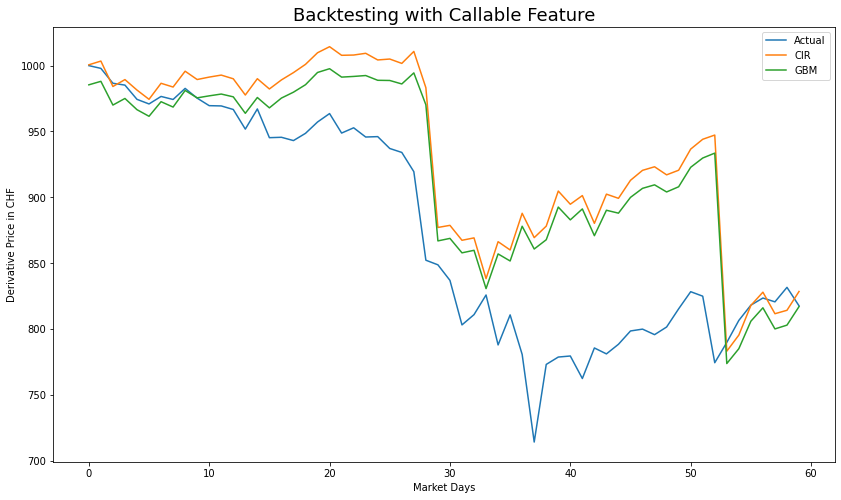

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Backtesting with Callable Feature',fontdict={"fontsize":18})

backtest_data_callable['Actual'].plot(legend=True)
backtest_data_callable['CIR'].plot(legend=True)
backtest_data_callable['GBM'].plot(legend=True)

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in CHF')

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mean_abs_error=mean_absolute_error(backtest_data_callable['Actual'].to_list(),backtest_data_callable['GBM'].to_list())
mean_sq_error=mean_squared_error(backtest_data_callable['Actual'].to_list(),backtest_data_callable['GBM'].to_list())

print(f'Mean Absolute Error for GBM : {mean_abs_error}')
print(f'Mean Squared Error for GBM : {mean_sq_error}')
print()

mean_abs_error=mean_absolute_error(backtest_data_callable['Actual'].to_list(),backtest_data_callable['CIR'].to_list())
mean_sq_error=mean_squared_error(backtest_data_callable['Actual'].to_list(),backtest_data_callable['CIR'].to_list())

print(f'Mean Absolute Error for CIR : {mean_abs_error}')
print(f'Mean Squared Error for CIR : {mean_sq_error}')
print()

Mean Absolute Error for GBM : 50.34225946282142
Mean Squared Error for GBM : 4394.528710848604

Mean Absolute Error for CIR : 58.63175261372172
Mean Squared Error for CIR : 5673.507183555261



### Comparison between callable and non-callable

Text(0, 0.5, 'Derivative Price in CHF')

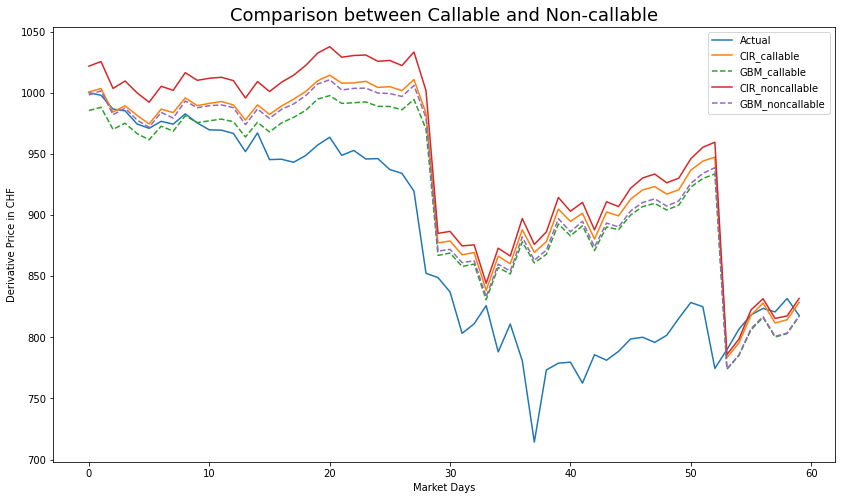

In [ ]:
plt.figure(figsize=(14,8))
plt.title('Comparison between Callable and Non-callable',fontdict={"fontsize":18})

backtest_data_callable['Actual'].plot(legend=True)
backtest_data_callable['CIR'].plot(legend=True, label='CIR_callable')
backtest_data_callable['GBM'].plot(legend=True, style='--', label='GBM_callable')
backtest_data['CIR'].plot(legend=True, label='CIR_noncallable')
backtest_data['GBM'].plot(legend=True, style='--', label='GBM_noncallable')

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in CHF')

## Implied Volatility Model


### With Bloomberg data (on CSGN.SW stock)

on 15 Aug 2022

In [ ]:
call_df = pd.read_csv("CALL_15aug22.csv")
call_df.replace(0, np.nan, inplace=True)
print("number of nans",call_df.isna().sum().sum())
call_df.dropna(inplace=True)
call_df

number of nans 16


,Days To Maturity,Strike,Mid,IVM
0,67,3.80,1.670000,61.199051
1,67,3.85,1.619999,59.401112
2,67,3.90,1.569999,57.620430
3,67,3.95,1.520000,55.857925
4,67,4.00,1.480000,56.980610
...,...,...,...,...
499,487,17.00,0.060000,51.688309
500,487,18.00,0.045000,51.165897
501,487,19.00,0.045000,52.920822
502,487,20.00,0.040000,53.594860


In [ ]:
call_df['TTM'] = call_df['Days To Maturity']/252
call_df['ATM'] = np.log(call_df['Mid']/call_df['Strike'])
call_df['IV'] = call_df['IVM']/100

Text(0.5, 0, 'ImpliedVolatility')

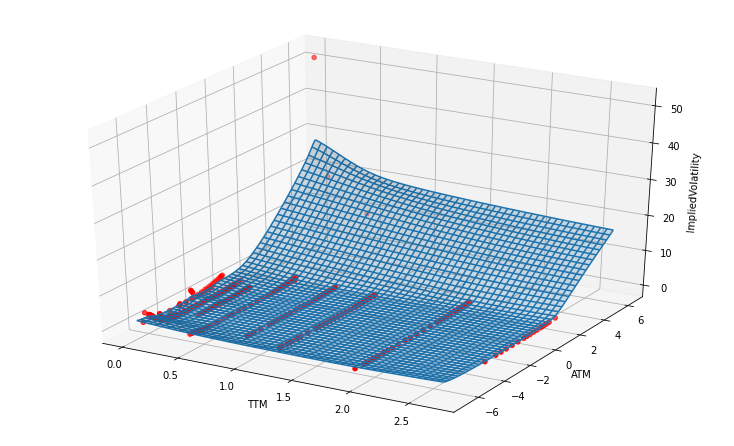

In [ ]:
x = call_df['TTM']
y = call_df['ATM']
z = call_df['IV']

x_grid = np.linspace(x.min(), x.max(), len(x))
y_grid = np.linspace(y.min(), y.max(), len(y))
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

spline_0 = sp.interpolate.Rbf(x,y,z,function='multiquadric', smooth=5)
Z = spline_0(B1, B2)
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel('TTM')
ax.set_ylabel('ATM')
ax.set_zlabel('ImpliedVolatility')

In [ ]:
Nsim=10000
dt=1/252
date = 0
delta = 252-date
tau=delta/252
# find r
v, sd = get_statistics(prices_array[date], dt)
curve_fit=curves[date]
r = curve_fit(tau)/100
returns_sim = simGBMpath_iv(Nsim, 5.42, r, 1, dt, tau, spline_0, Z[date])
payoff_sim = np.apply_along_axis(payoff, 1, returns_sim,1-tau)
exdates = [126-date, 189-date]
exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
extimes = len(exdates)
# initialize matrix
V = np.zeros((Nsim, extimes+1))
exmat = np.zeros((Nsim, extimes))
V[:,-1] = payoff_sim
previousstep = delta
for i,j in enumerate(exdates[::-1]):
  currentstep = j
  # assume all are ITM points
  Y=np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)]
  X=returns_sim[:,currentstep]
  X2=X**2
  X = np.reshape(X, (-1,1))
  X = np.insert(X, 1, X2, axis=1)
  LR = LinearRegression().fit(X, Y)
  F = LR.predict(X)
  #print("coefficients: ",LR.coef_)
  shouldRedeem = np.where(redemption_cost((currentstep+date)*dt) < F, 1, 0)
  exmat[:,-(i+1)] = shouldRedeem
  newvalues = np.where(shouldRedeem, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)])
  V[:, -(i+2)] = newvalues
  previousstep=j

v0=np.exp(-r*(previousstep-0)*dt)*np.mean(V[:,0])
times_call = np.count_nonzero(exmat, axis=None)

<ipython-input-75-e09ceb3f7d96>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simGBMpath_iv" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-75-e09ceb3f7d96> (3)

File "<ipython-input-75-e09ceb3f7d96>", line 3:
def simGBMpath_iv(nsim, s0, v, sd, deltat, tau, spline, Z=-1):
  m = int(tau/deltat) #number of periods
  ^

  @jit
<ipython-input-75-e09ceb3f7d96>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "simGBMpath_iv" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-75-e09ceb3f7d96>", line 6:
def simGBMpath_iv(nsim, s0, v, sd, deltat, tau, spline, Z=-1):
    <source elided>
  Z = np.random.normal(0,1,size=(nsim, m))
  for i in range(nsim):
  ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Fu

In [ ]:
print("v0: ",v0)
print("number of times called: ", times_call)

v0:  742.9493325565337
number of times called:  1944


on 8 Nov 2022

In [ ]:
call_df = pd.read_csv("CALL_8nov22.csv")
call_df.replace(0, np.nan, inplace=True)
print("number of nans",call_df.isna().sum().sum())
call_df.dropna(inplace=True)
call_df

number of nans 33


,Days To Maturity,Strike,Mid,IVM
6,403,1.8,2.230,39.320983
7,403,2.0,2.060,44.633898
8,403,2.4,1.750,48.576542
9,403,2.8,1.470,49.339507
10,403,3.2,1.380,61.229668
...,...,...,...,...
549,74,5.4,0.065,54.469570
550,74,5.5,0.060,55.484055
551,74,5.6,0.055,56.329631
552,74,5.7,0.050,57.001387


In [ ]:
call_df['TTM'] = call_df['Days To Maturity']/252
call_df['ATM'] = np.log(call_df['Mid']/call_df['Strike'])
call_df['IV'] = call_df['IVM']/100

Text(0.5, 0, 'ImpliedVolatility')

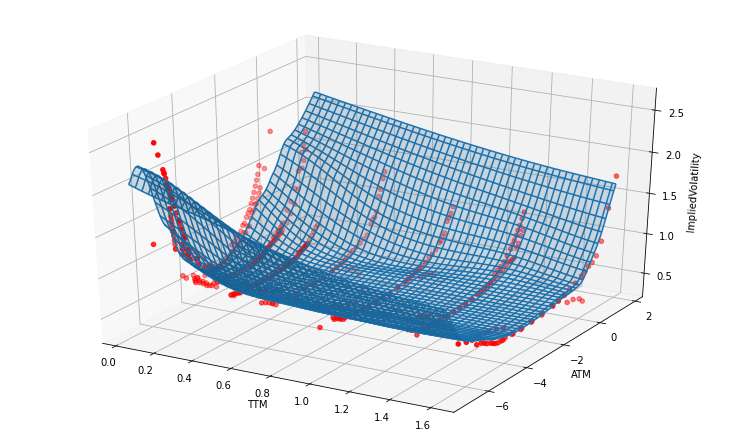

In [ ]:
x = call_df['TTM']
y = call_df['ATM']
z = call_df['IV']

x_grid = np.linspace(x.min(), x.max(), len(x))
y_grid = np.linspace(y.min(), y.max(), len(y))
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

spline_61 = sp.interpolate.Rbf(x,y,z,function='multiquadric', smooth=5)
Z = spline_61(B1, B2)
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')
ax.set_xlabel('TTM')
ax.set_ylabel('ATM')
ax.set_zlabel('ImpliedVolatility')


In [ ]:
Nsim=10000
dt=1/252
date = 61
delta = 252-date
tau=delta/252
# find r
v, sd = get_statistics(prices_array[date], dt)
curve_fit=curves[date-1]
r = curve_fit(tau)/100
returns_sim = simGBMpath_iv(Nsim, 5.42, r, 1, dt, tau, spline_61, Z[date])
payoff_sim = np.apply_along_axis(payoff, 1, returns_sim,1-tau)
exdates = [126-date, 189-date]
exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
extimes = len(exdates)
# initialize matrix
V = np.zeros((Nsim, extimes+1))
exmat = np.zeros((Nsim, extimes))
V[:,-1] = payoff_sim
previousstep = delta
for i,j in enumerate(exdates[::-1]):
  currentstep = j
  # assume all are ITM points
  Y=np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)]
  X=returns_sim[:,currentstep]
  X2=X**2
  X = np.reshape(X, (-1,1))
  X = np.insert(X, 1, X2, axis=1)
  LR = LinearRegression().fit(X, Y)
  F = LR.predict(X)
  #print("coefficients: ",LR.coef_)
  shouldRedeem = np.where(redemption_cost((currentstep+date)*dt) < F, 1, 0)
  exmat[:,-(i+1)] = shouldRedeem
  newvalues = np.where(shouldRedeem, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)])
  V[:, -(i+2)] = newvalues
  previousstep=j

v0=np.exp(-r*(previousstep-0)*dt)*np.mean(V[:,0])
times_call = np.count_nonzero(exmat, axis=None)

In [ ]:
print("v0: ",v0)
print("number of times called: ", times_call)

v0:  755.8470833218722
number of times called:  1459


## Heston Model (in a separate notebook)
